Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load data

In [41]:
file_path1 = r"C:\Users\Samsung\Desktop\CDT406-Smart-Gripper\models_LOCKED\LSTM_STFT_search\cv_results.csv"
file_path2 = r"C:\Users\Samsung\Desktop\CDT406-Smart-Gripper\models_LOCKED\LSTM_STFT_Dense_search\cv_results.csv"
file_path3 = r"C:\Users\Samsung\Desktop\CDT406-Smart-Gripper\models_LOCKED\LSTM_search\cv_results.csv"

df = pd.read_csv(file_path1)
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)
df3 = pd.read_csv(file_path3)

print("df1:")
print(df1.head())

print("\ndf2:")
print(df2.head())

print("\ndf3:")
print(df3.head())



df1:
  architecture  preproc_variant  val_subject        f1  hp_trial
0    LSTM_STFT                1            1  0.730928  trial_10
1    LSTM_STFT                1            2  0.550402  trial_10
2    LSTM_STFT                1            3  0.374891  trial_10
3    LSTM_STFT                1            4  0.643751  trial_10
4    LSTM_STFT                1            5  0.533100  trial_10

df2:
      architecture  preproc_variant  val_subject        f1  hp_trial
0  LSTM_STFT_Dense                1            1  0.487882  trial_13
1  LSTM_STFT_Dense                1            2  0.488064  trial_13
2  LSTM_STFT_Dense                1            3  0.528341  trial_13
3  LSTM_STFT_Dense                1            4  0.504009  trial_13
4  LSTM_STFT_Dense                1            5  0.487436  trial_13

df3:
  architecture  preproc_variant  val_subject        f1  hp_trial
0         LSTM                1            1  0.490285  trial_14
1         LSTM                1            2  0.4

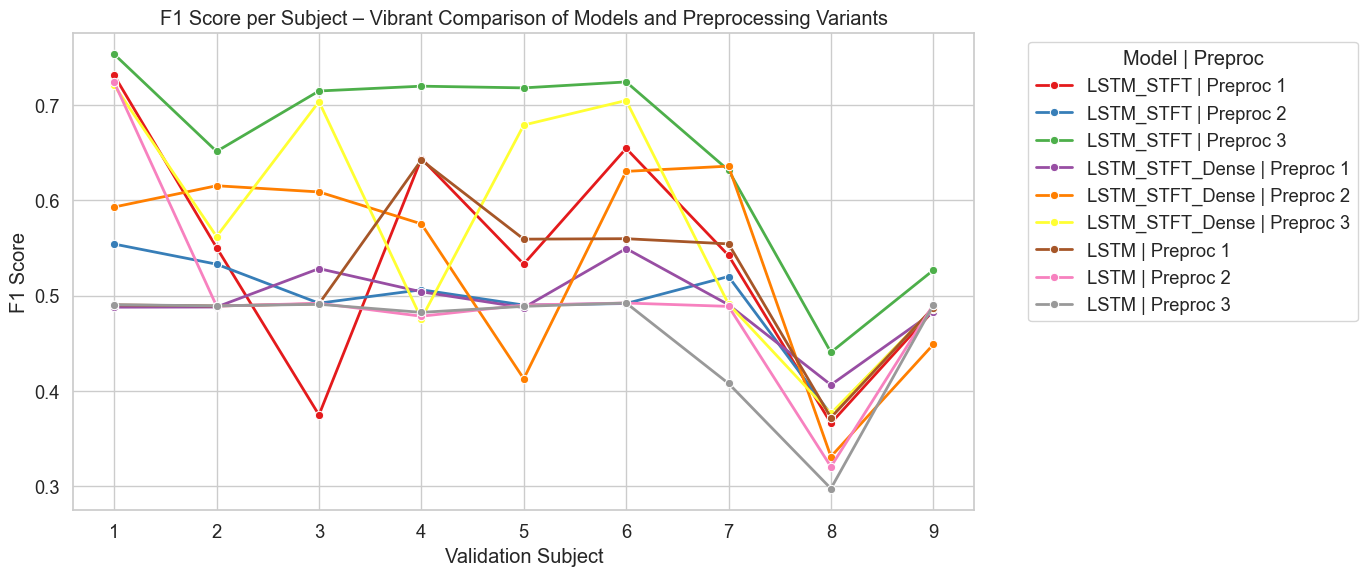

In [45]:
df3['model'] = 'LSTM'
df2['model'] = 'LSTM_STFT_Dense'
df1['model'] = 'LSTM_STFT'

df_all = pd.concat([df1, df2, df3])


df_all['label'] = df_all['model'] + ' | Preproc ' + df_all['preproc_variant'].astype(str)

sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("Set1", n_colors=df_all['label'].nunique())


plt.figure(figsize=(14, 6))
sns.lineplot(
    data=df_all,
    x='val_subject',
    y='f1',
    hue='label',
    palette=palette,
    marker='o',
    linewidth=2
)

plt.title('F1 Score per Subject – Vibrant Comparison of Models and Preprocessing Variants')
plt.xlabel('Validation Subject')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend(title='Model | Preproc', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

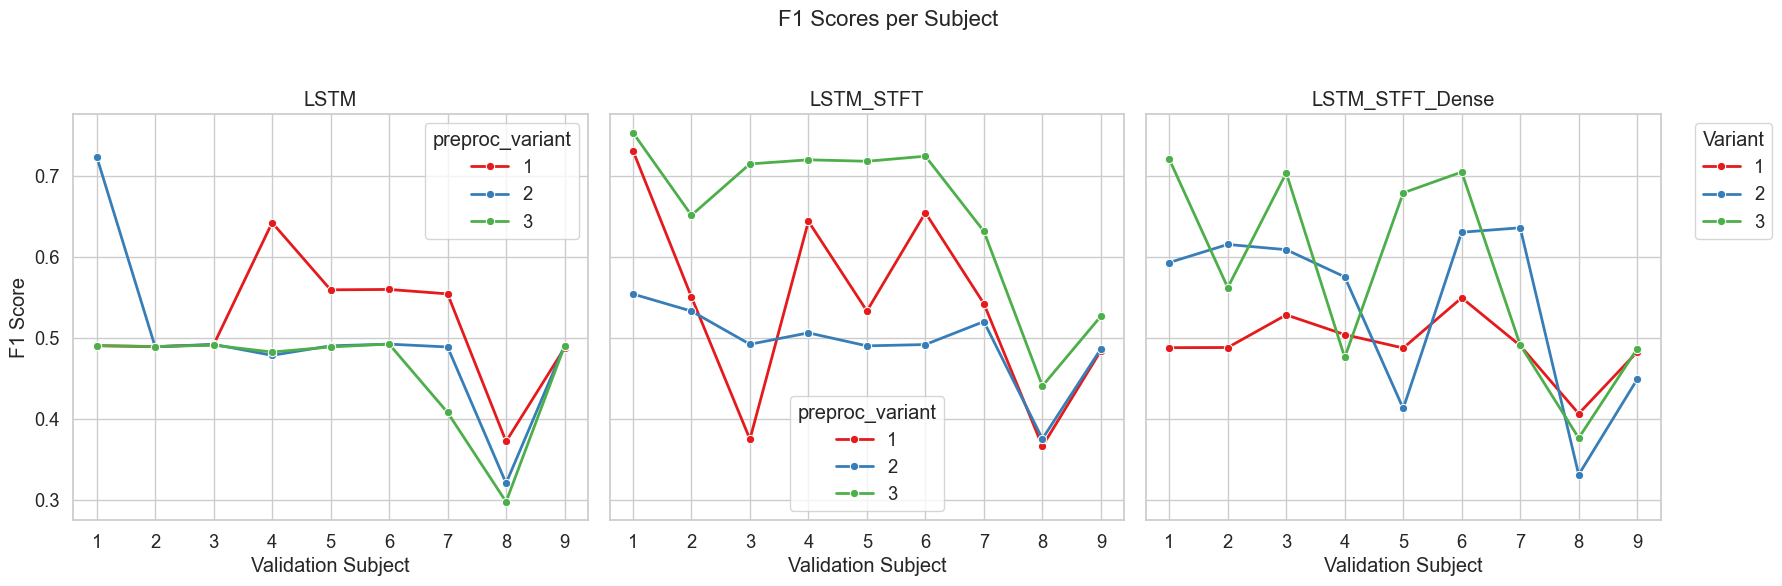

In [55]:
df3['model'] = 'LSTM'
df2['model'] = 'LSTM_STFT_Dense'
df1['model'] = 'LSTM_STFT'


df_all = pd.concat([df1, df2, df3])


sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("Set1", n_colors=3)


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, model in enumerate(sorted(df_all['model'].unique())):
    ax = axes[i]
    subset = df_all[df_all['model'] == model]

    sns.lineplot(
        data=subset,
        x='val_subject',
        y='f1',
        hue='preproc_variant',
        palette=palette,
        marker='o',
        linewidth=2,
        ax=ax
    )

    ax.set_title(model)
    ax.set_xlabel('Validation Subject')
    if i == 0:
        ax.set_ylabel('F1 Score')
    else:
        ax.set_ylabel('')
    ax.grid(True)


axes[2].legend(title='Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('F1 Scores per Subject', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Group by preproc_variant

In [25]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

In [22]:
summary_stats = df.groupby('preproc_variant')['f1'].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()
print("Summary statistics per preproc_variant:")
display(summary_stats)

Summary statistics per preproc_variant:


,preproc_variant,mean,std,min,max,median
0,1,0.542235,0.122960,0.366299,0.730928,0.542159
1,2,0.494332,0.050114,0.375442,0.554075,0.492074
2,3,0.653235,0.105518,0.440545,0.753104,0.714585


lineplot

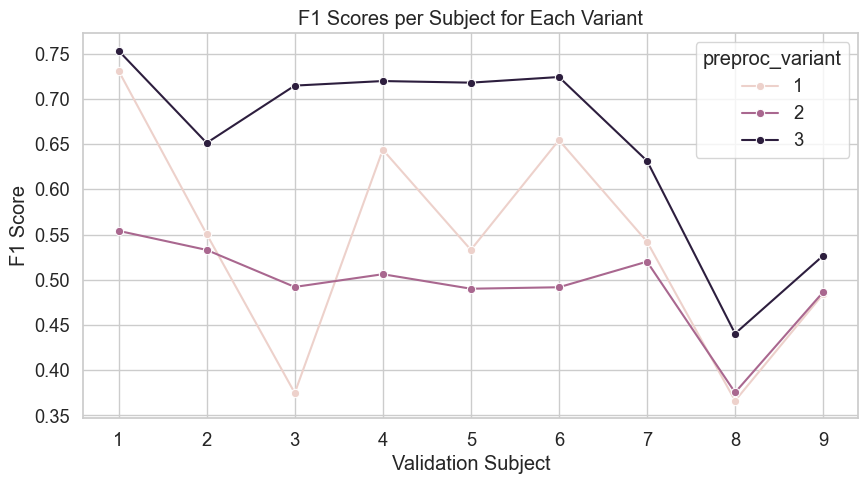

In [28]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='val_subject', y='f1', hue='preproc_variant', data=df, marker="o")
plt.title('F1 Scores per Subject for Each Variant')
plt.xlabel('Validation Subject')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [59]:
import pandas as pd

# Tag each model (already done)
df3['model'] = 'LSTM'
df2['model'] = 'LSTM_STFT_Dense'
df1['model'] = 'LSTM_STFT'

# Combine all models into one DataFrame
df_all = pd.concat([df1, df2, df3])

# Group by model and preproc_variant, compute mean and std
summary = df_all.groupby(['model', 'preproc_variant'])['f1'].agg(['mean', 'std']).reset_index()

# Rename columns
summary.columns = ['Model', 'Preprocessing Variant', 'Average F1', 'Standard Deviation']

# Format the output nicely (rounded values)
summary['Average F1'] = summary['Average F1'].apply(lambda x: f"{x:.3f}")
summary['Standard Deviation'] = summary['Standard Deviation'].apply(lambda x: f"{x:.3f}")

# Sort for readability
summary = summary.sort_values(by=['Model', 'Preprocessing Variant'])

# Print clean table
print("\n📊 F1 Score Summary by Model and Preprocessing Variant\n")
print(summary.to_string(index=False))



📊 F1 Score Summary by Model and Preprocessing Variant

          Model  Preprocessing Variant Average F1 Standard Deviation
           LSTM                      1      0.516              0.075
           LSTM                      2      0.496              0.102
           LSTM                      3      0.459              0.066
      LSTM_STFT                      1      0.542              0.123
      LSTM_STFT                      2      0.494              0.050
      LSTM_STFT                      3      0.653              0.106
LSTM_STFT_Dense                      1      0.492              0.039
LSTM_STFT_Dense                      2      0.539              0.112
LSTM_STFT_Dense                      3      0.578              0.127
